In [1]:
from PIL import Image, ImageChops
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random

from torchvision.transforms import ToPILImage
from skimage.metrics import structural_similarity as SSIM
from skimage.metrics import mean_squared_error as MSE
to_pil = ToPILImage()


In [2]:
def get_ssim_score(img, img_rec):
    ssim_score = SSIM(img, img_rec)
    return ssim_score

def get_mse_dif(img, img_rec):
    mse_error = MSE(img, img_rec)
    return mse_error

In [3]:
# Ground truth reconstruction comparision for mse and ssim

eval_dir = "../evaluation_output"
orig_dataset_dir = "../data/Eval"

diff_ssim_sum = 0
diff_mse_sum = 0
for idx, seq_dir in enumerate(os.listdir(eval_dir)):
    gt_path = os.path.join(orig_dataset_dir, seq_dir, "gt.png")
    gt_img = np.array(Image.open(gt_path).resize((256, 256)))[:, :, :3]

    gt_rec_path = os.path.join(eval_dir, seq_dir, "gt_reconstruction.png")
    gt_rec_img = np.array(Image.open(gt_rec_path))

    gt_img_gray = np.array(Image.fromarray(gt_img).convert("L"))
    gt_rec_img_gray = np.array(Image.fromarray(gt_rec_img).convert("L"))

    diff_mse = get_mse_dif(gt_img, gt_rec_img)
    diff_mse_sum += diff_mse
    
    ssim_score = get_ssim_score(gt_img_gray, gt_rec_img_gray)
    diff_ssim_sum += ssim_score
    # plt.show()
    
diff_ssim_sum /= 100
diff_mse_sum /= 100
print("Average ssim score: ", diff_ssim_sum)
print("Average mse error: ", diff_mse_sum)



Average ssim score:  0.6229311050016196
Average mse error:  3730.443632354736


In [4]:
# Random ground truth comparision

eval_dir = "../evaluation_output"
orig_dataset_dir = "../data/Eval"

diff_ssim_sum = 0
diff_mse_sum = 0

for idx, seq_dir in enumerate(os.listdir(eval_dir)):
    n= len(os.listdir(eval_dir)) -1
    
    random_idx = random.randint(0, n)
    while random_idx == idx:
        random_idx = random.randint(0, n)
    
    gt_path = os.path.join(orig_dataset_dir, seq_dir, "gt.png")
    gt_img = np.array(Image.open(gt_path).resize((256, 256)))[:, :, :3]
    
    random_seq_dir = os.listdir(eval_dir)[random_idx]
    random_gt_path = os.path.join(orig_dataset_dir, random_seq_dir, "gt.png")
    random_gt_img = np.array(Image.open(random_gt_path).resize((256, 256)))[:, :, :3]
    
    gt_img_gray = np.array(Image.fromarray(gt_img.astype(np.uint8)).convert("L"))
    random_gt_img_gray = np.array(Image.fromarray(random_gt_img.astype(np.uint8)).convert("L"))
    
    diff_ssim = get_ssim_score(gt_img_gray, random_gt_img_gray)
    diff_ssim_sum += diff_ssim
    
    diff_mse = get_mse_dif(gt_img, random_gt_img)
    diff_mse_sum += diff_mse


    
diff_mse_sum /= 100
diff_ssim_sum /= 100
print("Average mse error: ", diff_mse_sum)
print("Average SSIM error: ", diff_ssim_sum)

Average mse error:  9074.133215637203
Average SSIM error:  0.13453154850276203


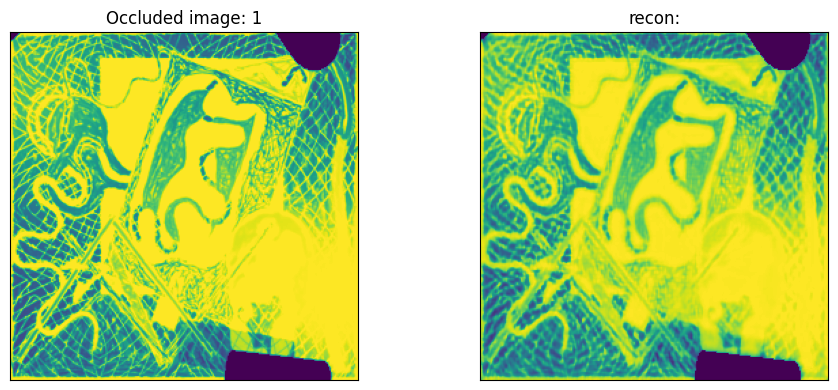

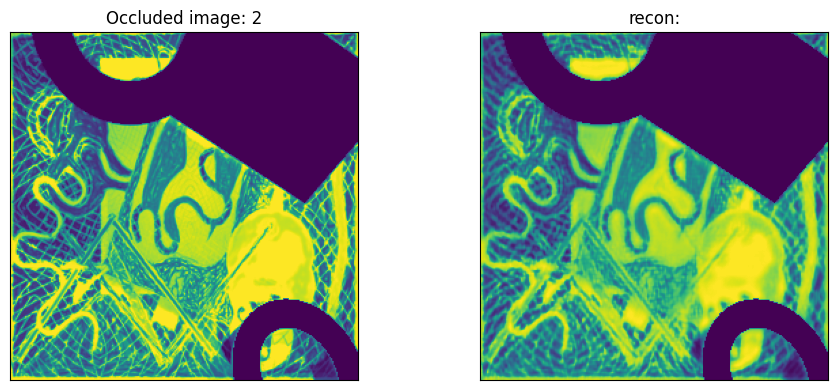

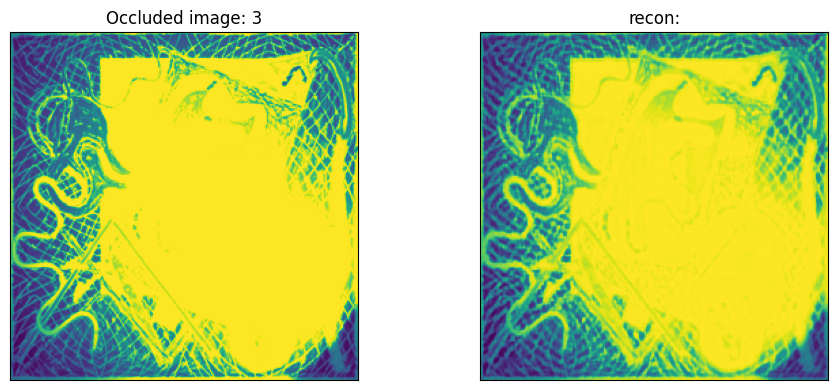

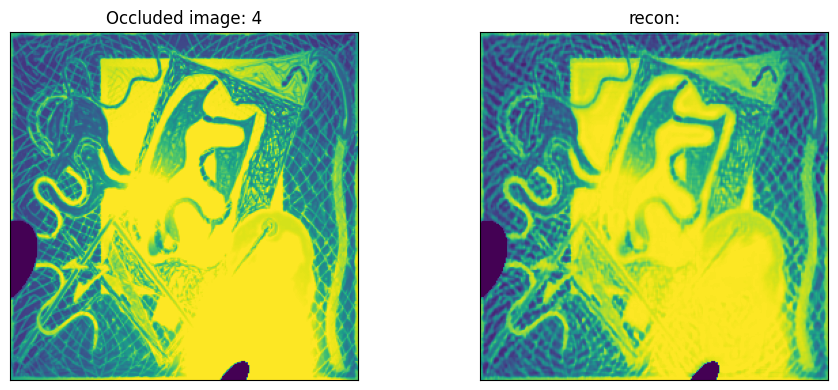

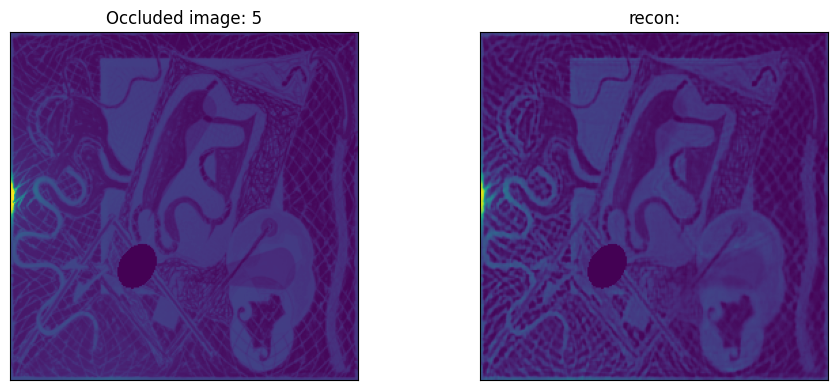

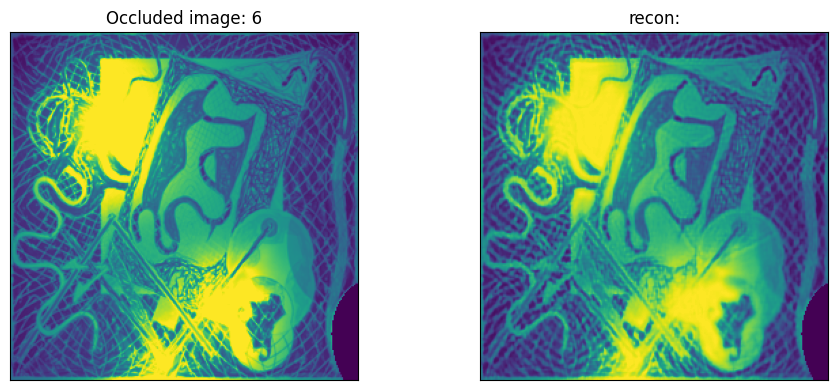

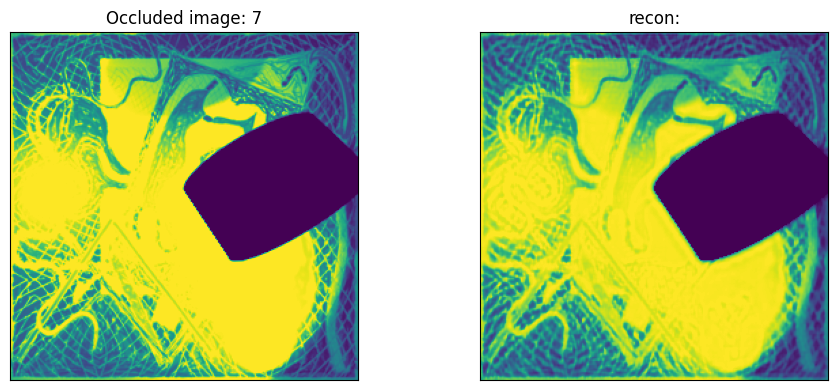

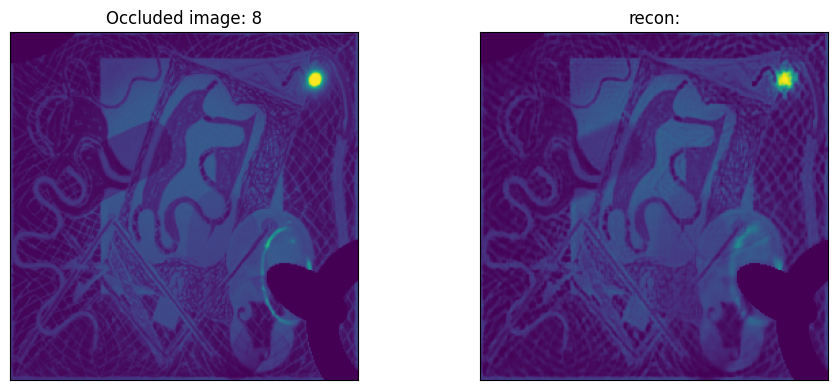

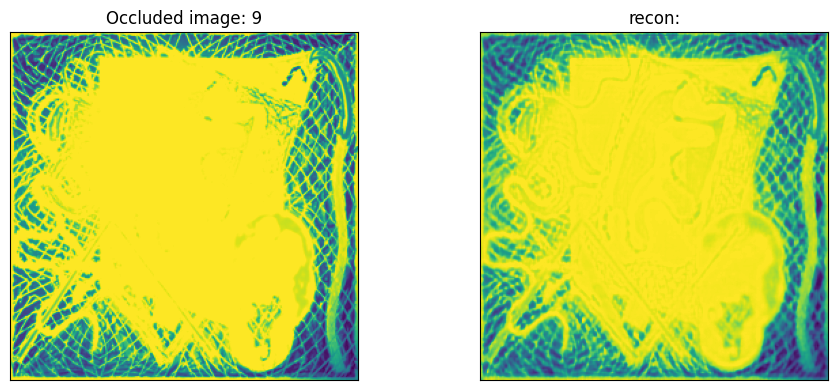

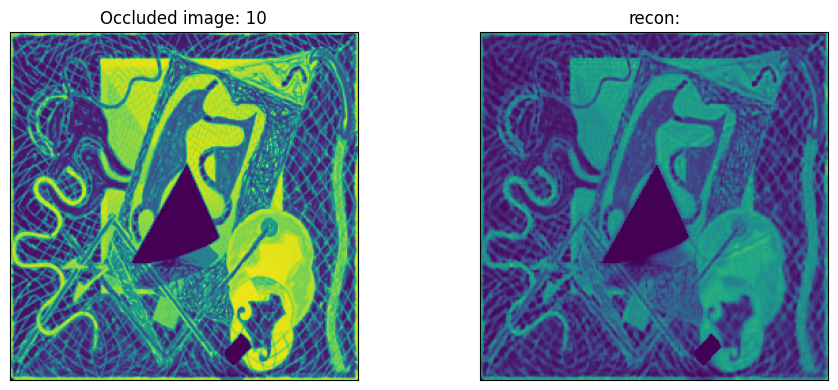

SSIM:  0.8846675626677893
MSE:  225.80928141276044


In [6]:
# FINAL! comparision of occluded masked image with masked (gt_rec * shadow) + light
show_reconstruction = False

eval_dir = "../evaluation_output"
orig_dataset_dir = "../data/Eval"

diff_ssim_sum = 0
diff_mse_sum = 0
count = 0
for idx, seq_dir in enumerate(os.listdir(eval_dir)):
    gt_rec_path = os.path.join(eval_dir, seq_dir, "gt_reconstruction.png")
    gt_rec = np.array(Image.open(gt_rec_path).resize((256, 256)))
    
    gt_path = os.path.join(orig_dataset_dir, seq_dir, "gt.png")
    gt_img = np.array(Image.open(gt_path).resize((256, 256)))[:, :, :3]
    if(seq_dir != "650"):
      continue
    for i in range(10):
        
        orig_occ_binary_path = os.path.join(orig_dataset_dir, seq_dir, str(i+1) + "-m.png")
        orig_occ_binary_img = np.array(Image.open(orig_occ_binary_path).resize((256, 256)))[:, :, :3]
        orig_occ_binary_img_inv = np.where(orig_occ_binary_img ==255, np.zeros(orig_occ_binary_img.shape), np.ones(orig_occ_binary_img.shape))
        
        ocl_path = os.path.join(orig_dataset_dir, seq_dir, str(i+1) + ".png")
        ocl_img = np.array(Image.open(ocl_path).resize((256, 256)))[:, :, :3]
        
        ocl_img_filtered = ocl_img * orig_occ_binary_img_inv

        shadow_i_path = os.path.join(eval_dir, seq_dir, "shadow_" + str(i+1) + ".png")
        shadow_i = np.array(Image.open(shadow_i_path)) / 255.0
        
        light_i_path = os.path.join(eval_dir, seq_dir, "light_" + str(i+1) + ".png")
        light_i = np.array(Image.open(light_i_path), dtype = np.int32)
        
        gt_rec_multi_add = np.array((gt_rec * shadow_i + light_i) * orig_occ_binary_img_inv, dtype=np.int32).clip(max = 255)
        

        gt_rec_multi_add_gray = np.array(Image.fromarray(gt_rec_multi_add.astype(np.uint8)).convert("L"))
        ocl_img_filtered_gray = np.array(Image.fromarray(ocl_img_filtered.astype(np.uint8)).convert("L"))
        
        ssim_score = get_ssim_score(ocl_img_filtered_gray, gt_rec_multi_add_gray)
        diff_ssim_sum += ssim_score
        mse_diff = get_mse_dif(ocl_img_filtered, gt_rec_multi_add)
        diff_mse_sum += mse_diff
        count += 1
        

        if show_reconstruction:
          fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4),
                              sharex=True, sharey=True)

          ax = axes.ravel()

          ax[0].imshow(ocl_img_filtered_gray)
          ax[0].set_title(f'Occluded image: {str(i+1)}')
          ax[0].tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
          
          ax[1].imshow(gt_rec_multi_add_gray)
          ax[1].set_title('recon:')
          ax[1].tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)

  
          plt.tight_layout()
          plt.show()


print("SSIM: ", diff_ssim_sum / count)
print("MSE: ", diff_mse_sum / count)
